# Run relative flammability for CMIP5 ALFRESCO outputs

This notebooks orchestrates the computation of relative flammability using the `https://github.com/ua-snap/alfresco_postprocessing/bin/alfresco_relative_flammability.py` script and slurm.

To run this processing, that script must be present on the system and the path to it should be stored in the `REL_FLAM_SCRIPT_PATH` variable. 

The path to write the new relative flammability data should be stored in `OUTPUT_DIR` and the main directory containing the ALFRESCO outputs (typically a subfolder named `FMO_Calibrated/`) should be stored in the `BASE_DIR` environment variable. The `SCRATCH_DIR` variable can be used to specify the path for the `sbatch` scripts and slurm output scripts, but this defaults to 

Any of these may be set in the code cell below as well. 

In [1]:
import os
from pathlib import Path
from itertools import product


# user paramater, wipe slurm dir if True
wipe_slurm = True

# setup paths
# set path to relative flammability script
relflam_fp = Path(os.getenv("REL_FLAM_SCRIPT_PATH") or "/workspace/UA/kmredilla/alfresco_postprocessing/bin/alfresco_relative_flammability.py")
# thesse are also available on Poseidon currently but there could be some read savings 
base_dir = Path(os.getenv("BASE_DIR") or "/atlas_scratch/apbennett/Calibration/HighCalib/FMO_Calibrated/")
output_dir = Path(os.getenv("OUTPUT_DIR") or "/atlas_scratch/kmredilla/aalfresco")
scratch_dir = Path(os.getenv("SCRATCH_DIR") or "/atlas_scratch/kmredilla/aalfresco")

print("Base dir: ", base_dir)
print("Output dir: ", output_dir)
print("Scratch dir: ", scratch_dir)

relflam_dir = output_dir.joinpath("relative_flammability")
relflam_dir.mkdir(exist_ok=True, parents=True)
# folder for slurm scripts in $SCRATCH
slurm_dir = scratch_dir.joinpath("slurm")
slurm_dir.mkdir(exist_ok=True, parents=True)
if wipe_slurm:
    _ = [fp.unlink() for fp in slurm_dir.glob("*")]

Base dir:  /atlas_scratch/apbennett/Calibration/HighCalib/FMO_Calibrated
Output dir:  /atlas_scratch/kmredilla/aalfresco
Scratch dir:  /atlas_scratch/kmredilla/aalfresco


Define a function for writing the `sbatch` commands to `.slurm` scripts:

In [45]:
def write_sbatch(ncpus, slurm_email, slurm_dir, ac_conda_env, relflam_fp, relflam_args):
    """Write the SBATCH `.slurm` scripts for each model/season regression
    
    Args:
        ncpus (int): number of cpus to allocate per job
        slurm_email (str): email address for sending slurm messages
        slurm_dir (PosixPath): path to directory to write sbatch .slurm files
        ac_conda_env (str): name of the conda env that has anaconda-project installed
        relflam_fp (PosixPath): path to script for processing the relative flammability
        relflam_args (dict): dictionary containing args for the relative flammability 
            processing script
        
    Returns:
        filepath of `.slurm` script 
    """
    out_fp = relflam_args["out_fp"]
    head = (
        "#!/bin/sh\n"
        + "#SBATCH --nodes=1\n"
        + f"#SBATCH --cpus-per-task={ncpus}\n"
        + "#SBATCH --account=snap\n"
        + "#SBATCH --mail-type=FAIL\n"
        + f"#SBATCH --mail-user={slurm_email}\n"
        + f"#SBATCH --output={slurm_dir}/{out_fp.name.replace('.tif', '_slurm_%j.out')}\n"
        + "#SBATCH -p main\n\n"
    )
    
    args = (
        # print start time
        "echo Start slurm && date\n"
        # initialize shell to use conda, 
        'eval "$(conda shell.bash hook)"\n'
        # activate env with anaconda-project installed
        f"conda activate {ac_conda_env}\n"
        # call the python regression script
        f"python {relflam_fp} "
        f"-p {relflam_args['maps_dir']} "
        f"-o {out_fp} "
        # just use the number of cores allocated for slurm
        f"-nc {ncpus} "
        f"-by {relflam_args['begin_year']} "
        f"-ey {relflam_args['end_year']}"
    )
    
    slurm_fp = slurm_dir.joinpath(out_fp.name.replace(".tif", ".slurm"))
    with open(slurm_fp, "w") as f:
        f.write(head + args)

    return slurm_fp

### Historical eras

For the historical eras, need to execute a bit differently - since all models have identical outputs for this period, just need to run one model (any) and scenario (any).

In [40]:
def make_sbatch_scripts(relflam_args_list, ncpus, slurm_email, ac_conda_env, relflam_fp):
    """Create the sbatch scripts for each of the argument sets in relflam_args_list"""
    slurm_fps = [
        write_sbatch(
            ncpus, slurm_email, slurm_dir, ac_conda_env, relflam_fp, args
        ) 
        for args in relflam_args_list
    ]

    print(f"{len(slurm_fps)} slurm scripts written to {slurm_dir}")
    
    return slurm_fps

Create the list of args for historical relative flammability jobs:

In [33]:
historical_eras = ["1950-2008"]
historical_eras.extend([f"19{i}0-19{i}9" for i in range(5, 10)])
historical_eras.append("2000-2008")

historical_models = ["GFDL-CM3"]
historical_scenarios = ["rcp45"]

historical_relflam_args_list = []
for era, model, scenario in product(historical_eras, historical_models, historical_scenarios):
    temp_out_fn = f"alfresco_relative_flammability_{era}_historical_NoFMO.tif"
    temp_maps_dir = base_dir.joinpath(f"{model}_{scenario}_NoFMO/Maps")
    begin_year, end_year = era.split("-")

    # relative flammability script args
    historical_relflam_args_list.append({
        "maps_dir": temp_maps_dir,
        "out_fp": relflam_dir.joinpath(temp_out_fn),
        "begin_year": begin_year,
        "end_year": end_year,
    })

Set the sbatch options for all jobs:

In [38]:
# slurm args

# number of cores
ncpus = 32
# slurm email
slurm_email = "kmredilla@alaska.edu"
# name of the conda env that has anaconda-project installed
ac_conda_env = "/home/UA/kmredilla/miniconda3/envs/py38"

Make the sbatch scripts:

In [41]:
historical_slurm_fps = make_sbatch_scripts(historical_relflam_args_list, ncpus, slurm_email, ac_conda_env, relflam_fp)
_ = [print(fp.name) for fp in historical_slurm_fps]

7 slurm scripts written to /atlas_scratch/kmredilla/aalfresco/slurm
alfresco_relative_flammability_1950-2008_historical_NoFMO.slurm
alfresco_relative_flammability_1950-1959_historical_NoFMO.slurm
alfresco_relative_flammability_1960-1969_historical_NoFMO.slurm
alfresco_relative_flammability_1970-1979_historical_NoFMO.slurm
alfresco_relative_flammability_1980-1989_historical_NoFMO.slurm
alfresco_relative_flammability_1990-1999_historical_NoFMO.slurm
alfresco_relative_flammability_2000-2008_historical_NoFMO.slurm


### Future eras

For future eras, doing all combinations of model / scenario / era. Setup the args:

In [18]:
# iterate over remaining model / scenario / periods and setup args for processing
eras = ["2040-2069", "2070-2099"]
eras.extend([f"20{i}0-20{i}9" for i in range(1, 10)])
models = ["GFDL-CM3", "CCSM4", "GISS-E2-R", "IPSL-CM5A-LR", "MRI-CGCM3"]
scenarios = ["rcp45", "rcp60", "rcp85"]

relflam_args_list = []
for era, model, scenario in product(eras, models, scenarios):
    temp_out_fn = f"alfresco_relative_flammability_{era}_{model}_{scenario}_NoFMO.tif"
    temp_maps_dir = base_dir.joinpath(f"{model}_{scenario}_NoFMO/Maps")
    begin_year, end_year = era.split("-")
    
    # relative flammability script args
    relflam_args_list.append({
        "maps_dir": temp_maps_dir,
        "out_fp": relflam_dir.joinpath(temp_out_fn),
        "begin_year": begin_year,
        "end_year": end_year,
    })

In [19]:
slurm_fps = make_sbatch_scripts(relflam_args_list, ncpus, slurm_email, ac_conda_env, relflam_fp)
_ = [print(fp.name) for fp in slurm_fps[:10]]

165 slurm scripts written to /atlas_scratch/kmredilla/aalfresco/slurm
alfresco_relative_flammability_2040-2069_GFDL-CM3_rcp45_NoFMO.slurm
alfresco_relative_flammability_2040-2069_GFDL-CM3_rcp60_NoFMO.slurm
alfresco_relative_flammability_2040-2069_GFDL-CM3_rcp85_NoFMO.slurm
alfresco_relative_flammability_2040-2069_CCSM4_rcp45_NoFMO.slurm
alfresco_relative_flammability_2040-2069_CCSM4_rcp60_NoFMO.slurm
alfresco_relative_flammability_2040-2069_CCSM4_rcp85_NoFMO.slurm
alfresco_relative_flammability_2040-2069_GISS-E2-R_rcp45_NoFMO.slurm
alfresco_relative_flammability_2040-2069_GISS-E2-R_rcp60_NoFMO.slurm
alfresco_relative_flammability_2040-2069_GISS-E2-R_rcp85_NoFMO.slurm
alfresco_relative_flammability_2040-2069_IPSL-CM5A-LR_rcp45_NoFMO.slurm


### Submit all sbatch scripts

Submit all historical and future sbatch scripts:

In [99]:
# Call the slurm scripts with the `sbatch` command
_ = [os.system(f"sbatch {fp}") for fp in slurm_fps + historical_slurm_fps]

## Compute 5 model averages

Compute 5 model averages for all new future data.

In [76]:
import rasterio as rio


# get rasterio file metadata and mask from any complete file
relflam_fps = list(relflam_dir.glob("*"))
with rio.open(relflam_fps[0]) as src:
    meta = src.meta.copy()
    mask = src.read(1) == -9999
meta.update(compress='lzw')

In [80]:
relflam_dir

PosixPath('/atlas_scratch/kmredilla/aalfresco/relative_flammability')

In [83]:
import numpy as np
from tqdm.notebook import tqdm_notebook


# setup helper function for reading data from a tif
def read_tif(fp):
    with rio.open(fp) as src:
        arr = src.read(1)
    return arr

# iterate over eras, scenarios and average over models and save new rasters
mean_fps = []
avg_groups = list(product(eras, scenarios))
for era, scenario in tqdm_notebook(avg_groups):
    temp_fps = sorted(list(relflam_dir.glob(f"*{era}*{scenario}*.tif")))
    arrs = [read_tif(fp) for fp in temp_fps]
    mean_arr = np.round(np.array(arrs).mean(axis=0).astype(np.float32), 4)
    # sorted list will return CCSM4 data as first file
    temp_fn = temp_fps[0].name.replace("CCSM4", "5modelAvg")
    temp_out_fp = relflam_dir.joinpath(temp_fn)
    mean_fps.append(temp_out_fp)
    with rio.open(temp_out_fp, "w", **meta) as dst:
        dst.write(mean_arr, 1)

print(f"{len(mean_fps)} 5 model average files written to {relflam_dir}.")
_ = [print(fp.name) for fp in sorted(list(relflam_dir.glob("*5modelAvg*")))[:10]]

alfresco_relative_flammability_2010-2019_5modelAvg_rcp45_NoFMO.tif
alfresco_relative_flammability_2010-2019_5modelAvg_rcp60_NoFMO.tif
alfresco_relative_flammability_2010-2019_5modelAvg_rcp85_NoFMO.tif
alfresco_relative_flammability_2020-2029_5modelAvg_rcp45_NoFMO.tif
alfresco_relative_flammability_2020-2029_5modelAvg_rcp60_NoFMO.tif
alfresco_relative_flammability_2020-2029_5modelAvg_rcp85_NoFMO.tif
alfresco_relative_flammability_2030-2039_5modelAvg_rcp45_NoFMO.tif
alfresco_relative_flammability_2030-2039_5modelAvg_rcp60_NoFMO.tif
alfresco_relative_flammability_2030-2039_5modelAvg_rcp85_NoFMO.tif
alfresco_relative_flammability_2040-2049_5modelAvg_rcp45_NoFMO.tif


## Package files for rasdaman

Split the files up for ingestion into two different (historical and future) rasdaman coverages:

In [71]:
!mkdir -p /atlas_scratch/kmredilla/aalfresco/historical_relative_flammability
!cp /atlas_scratch/kmredilla/aalfresco/relative_flammability/*historical* /atlas_scratch/kmredilla/aalfresco/historical_relative_flammability

In [72]:
ls /atlas_scratch/kmredilla/aalfresco/historical_relative_flammability

alfresco_relative_flammability_1950-1959_historical_NoFMO.tif
alfresco_relative_flammability_1950-2008_historical_NoFMO.tif
alfresco_relative_flammability_1960-1969_historical_NoFMO.tif
alfresco_relative_flammability_1970-1979_historical_NoFMO.tif
alfresco_relative_flammability_1980-1989_historical_NoFMO.tif
alfresco_relative_flammability_1990-1999_historical_NoFMO.tif
alfresco_relative_flammability_2000-2008_historical_NoFMO.tif


In [73]:
!cd /atlas_scratch/kmredilla/aalfresco/ && zip -r historical_relative_flammability.zip historical_relative_flammability

  adding: historical_relative_flammability/ (stored 0%)
  adding: historical_relative_flammability/alfresco_relative_flammability_1950-1959_historical_NoFMO.tif (deflated 22%)
  adding: historical_relative_flammability/alfresco_relative_flammability_1950-2008_historical_NoFMO.tif (deflated 19%)
  adding: historical_relative_flammability/alfresco_relative_flammability_1960-1969_historical_NoFMO.tif (deflated 27%)
  adding: historical_relative_flammability/alfresco_relative_flammability_1970-1979_historical_NoFMO.tif (deflated 27%)
  adding: historical_relative_flammability/alfresco_relative_flammability_1980-1989_historical_NoFMO.tif (deflated 27%)
  adding: historical_relative_flammability/alfresco_relative_flammability_1990-1999_historical_NoFMO.tif (deflated 23%)
  adding: historical_relative_flammability/alfresco_relative_flammability_2000-2008_historical_NoFMO.tif (deflated 24%)


In [93]:
!mkdir -p /atlas_scratch/kmredilla/aalfresco/future_relative_flammability
!cp /atlas_scratch/kmredilla/aalfresco/relative_flammability/*rcp* /atlas_scratch/kmredilla/aalfresco/future_relative_flammability

In [94]:
!ls /atlas_scratch/kmredilla/aalfresco/future_relative_flammability | head -5

alfresco_relative_flammability_2010-2019_5modelAvg_rcp45_NoFMO.tif
alfresco_relative_flammability_2010-2019_5modelAvg_rcp60_NoFMO.tif
alfresco_relative_flammability_2010-2019_5modelAvg_rcp85_NoFMO.tif
alfresco_relative_flammability_2010-2019_CCSM4_rcp45_NoFMO.tif
alfresco_relative_flammability_2010-2019_CCSM4_rcp60_NoFMO.tif


In [98]:
!cd /atlas_scratch/kmredilla/aalfresco/ && zip -r future_relative_flammability.zip future_relative_flammability

## Check some outputs

Look at some of the outputs:

In [100]:
import rasterio as rio
from rasterio.plot import show

In [101]:
fps = list(relflam_dir.glob("*.tif"))

In [102]:
def show_relflam(fp):
    with rio.open(fp) as src:
        print(fp)
        show(src)

/atlas_scratch/kmredilla/aalfresco/relative_flammability/alfresco_relative_flammability_2020-2029_GFDL-CM3_rcp85_NoFMO.tif


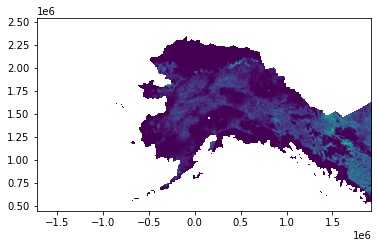

In [103]:
show_relflam(fps[0])

/atlas_scratch/kmredilla/aalfresco/relative_flammability/alfresco_relative_flammability_2040-2069_CCSM4_rcp60_NoFMO.tif


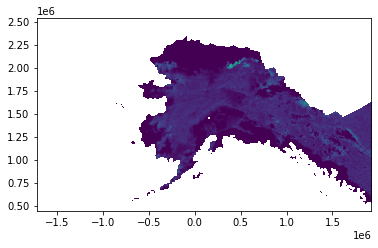

In [104]:
show_relflam(fps[10])

/atlas_scratch/kmredilla/aalfresco/relative_flammability/alfresco_relative_flammability_2040-2069_MRI-CGCM3_rcp85_NoFMO.tif


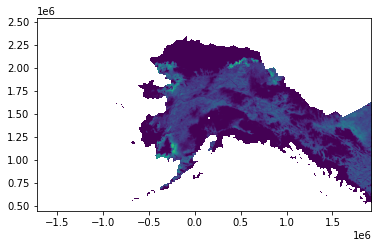

In [105]:
show_relflam(fps[20])